In [1]:
#Estudo de caso 5 do curso de Introduação à Ciência de Dados Aplicada à Cibersegurança

#Importando bibliotecas básicas

import numpy as np # vetores e matrizes 
import pandas as pd # processamento dos dados, arquivo CSV I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


# Jefferson Lopes
# Cibersegurança - 2024/1

In [2]:
# Importando a base de dados para o pandas

sms = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding = "ISO-8859-1", usecols=[0,1], skiprows=1,
                  names=["label", "message"])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
sms.label = sms.label.map({"ham":0, "spam":1})

In [4]:
# mais casos negativos (ham) que positivos (spams) 
sms.label.value_counts()

0    4825
1     747
Name: label, dtype: int64

In [5]:
#Dividindo a base em treino e teste
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(sms.message, 
                                                                            sms.label, 
                                                                            test_size=0.2)

In [6]:
# Criando o documento de treino

from sklearn.feature_extraction.text import CountVectorizer

couvec = CountVectorizer()
couvec.fit(features_train)

CountVectorizer()

In [7]:
# número de características ou tokens
trained_features = couvec.get_feature_names()
print("Número de características vetorizadas:", len(trained_features))
print("Exemplos de características treinadas:", trained_features[1:10])

Número de características vetorizadas: 7742
Exemplos de características treinadas: ['000', '000pes', '008704050406', '0089', '01223585236', '01223585334', '0125698789', '02', '0207']


In [8]:
# tokenized train documents

dtm_train = couvec.fit_transform(features_train)
print("Shape of dtm_train:", dtm_train.shape)
print(dtm_train[0:2]) # first two rows of sparse matrix

Shape of dtm_train: (4457, 7742)
  (0, 3441)	1
  (0, 3287)	1
  (0, 3174)	1
  (0, 2189)	1
  (0, 3349)	1
  (0, 7686)	1
  (0, 6390)	1
  (0, 6916)	1
  (0, 6159)	1
  (0, 6798)	1
  (0, 7421)	1
  (1, 6916)	1
  (1, 6798)	1
  (1, 6600)	1
  (1, 5526)	1
  (1, 7537)	1
  (1, 7499)	1
  (1, 6960)	1
  (1, 6305)	1
  (1, 2496)	1
  (1, 5235)	1
  (1, 3593)	1
  (1, 3951)	1
  (1, 7471)	1
  (1, 2041)	1
  (1, 911)	1
  (1, 3738)	1
  (1, 3633)	1
  (1, 7080)	1
  (1, 987)	1
  (1, 663)	1
  (1, 543)	1
  (1, 6337)	1
  (1, 7095)	1


In [9]:
# tokenized test documents

dtm_test = couvec.transform(features_test)
print("Shape of dtm_test:", dtm_test.shape)

Shape of dtm_test: (1115, 7742)


In [10]:
# Construíndo e avaliando o modelo 

# Multimodal Naive Bayes 
# O classificador multimodal Naive Bays é útil para classificar características discretas. 
# (e.g., número de palavras para classificação de textos). 
# A distribuição multimodal requer geralmente contadores inteiros como features.

# Importando e instanciando o modelo Nayve Bayes Multimodal
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [11]:
# Treinando o modelo

nb.fit(dtm_train, labels_train)

MultinomialNB()

In [12]:
# Fazendo predições

labels_pred = nb.predict(dtm_test)

In [13]:
# Acurácia
from sklearn import metrics
metrics.accuracy_score(labels_test, labels_pred)

0.9838565022421525

In [14]:
# Criando a matrix de confusão para precisão e recall (essas são duas outrss métricas de avaliação) 
metrics.confusion_matrix(labels_test, labels_pred)

array([[952,   5],
       [ 13, 145]])

In [15]:
# Percentagem do total de spams detectados i.e.recall
print("Recall:", metrics.recall_score(labels_test, labels_pred))

# Percentagem das predições positivas (spams) corretas, i.e. precisão
print("Precisão:", metrics.precision_score(labels_test, labels_pred))

Recall: 0.9177215189873418
Precisão: 0.9666666666666667


In [16]:
print("Ordem das classes no predict_proba:", nb.classes_)
print("Exemplos de probabilidades de classes:", nb.predict_proba(dtm_test)[0])


Ordem das classes no predict_proba: [0 1]
Exemplos de probabilidades de classes: [9.99976395e-01 2.36052344e-05]


In [17]:
# Uma vez que somente ~15% dos rótulos são positivos (spam), a curva precisão-recall é mais informativa que
# a curva ROC

labels_prob = nb.predict_proba(dtm_test)[:, 1]
precisions, recalls, thresholds = metrics.precision_recall_curve(labels_test, labels_prob)

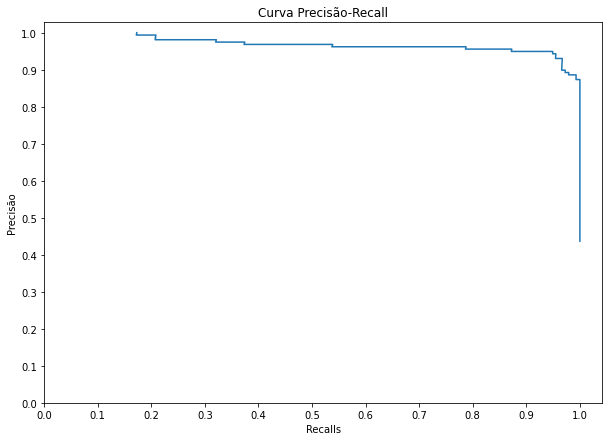

In [18]:
# Plotando a curva precisão-recall 

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisão")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Curva Precisão-Recall")
plt.show()

Acurácia: 0.9695
Precisão: 0.9921
Recall: 0.7911
Matriz de Confusão:
 [[956   1]
 [ 33 125]]


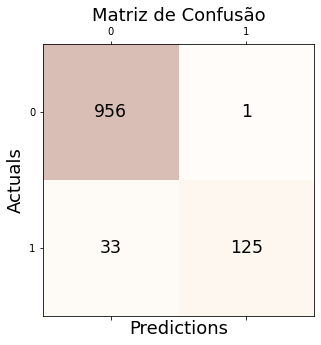

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

tfidf_vectorizer = TfidfVectorizer()
X_tfidf_train = tfidf_vectorizer.fit_transform(features_train)
X_tfidf_test = tfidf_vectorizer.transform(features_test)

lr_model = LogisticRegression()
lr_model.fit(X_tfidf_train, labels_train)

labels_pred_lr = lr_model.predict(X_tfidf_test)

accuracy_lr = accuracy_score(labels_test, labels_pred_lr)
precision_lr = precision_score(labels_test, labels_pred_lr, pos_label=1)
recall_lr = recall_score(labels_test, labels_pred_lr, pos_label=1)
confusion_lr = confusion_matrix(labels_test, labels_pred_lr)

print(f"Acurácia: {accuracy_lr:.4f}")
print(f"Precisão: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print("Matriz de Confusão:\n", confusion_lr)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion_lr, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(confusion_lr.shape[0]):
    for j in range(confusion_lr.shape[1]):
        ax.text(x=j, y=i, s=confusion_lr[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Matriz de Confusão', fontsize=18)
plt.show()


# Adicionei o TF IDF com mais análises